<img src="./images/DLI_Header.png">

# Scaling your Deep Learning Training

Welcome to the third lab of the course. So far, you've learned about stochastic gradient descent and the effects of batch size on training. You've also learned how to scale training from a single GPU to multiple GPUs. You should have seen a considerable speedup that we'll be measuring in more detail.

You've seen that as we scale to multiple GPUs, we effectively increase the batch size. From our testing in lab one, we know that increasing the batch size can increase throughput, but it can also affect a network's ability to train effectively. In this lab, you'll be exploring how training is affected when scaling to multiple GPUs. We will start with measuring the effect of multiple GPUs on throughput, in our case images per second. You'll then go on to learn tools and techniques that can help to maintain high accuracy as you scale.

## Scaling of Performance: Images/Second 

In the first lab, you evaluated images/second as a measurement of performance of the training. We saw that throughput increased with batch size, but only to a certain point. As the batch size increased to saturate the GPU memory, we saw diminishing returns. Now that we are scaling to multiple GPUs, it would make sense that our throughput would increase once again. How do you think throughput will scale with respect to the number of GPUs used in the training?

As in Lab 1, we have a callback that measures throughput in images/second after each epoch. Run the cell below __on one GPU__ and record the throughput in the code cell down below. As you might recall from Lab 1, throughput in the first epoch should be ignored because we are paying one-time costs, so choose a throughput from the second or third epoch.

In [1]:
!python3 fashion_mnist.py --epochs 3 --num-gpus 1 --batch-size 128

100%|█████████████████████████| 26421880/26421880 [00:02<00:00, 13113114.63it/s]
Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 324023.72it/s]
Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 6069752.49it/s]
Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

100%|█████████████████████████████████| 5148/5148 [00:00<00:00, 51288068.86it/s]
Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch =  1: Cumulative Time = 93.350, Epoch Time = 93.350, Images/sec = 641.7134399414062, Validation Loss = 0.630, Validation Accuracy = 0.763
Epoch =  2: Cumulative Time = 186.302, Epoch Time = 92.952, Images/sec = 644.4638061523438, Validation Loss = 0.374, Validation Accuracy = 0.864
Epoch =  3: Cumulative Time =

Next, alter the training to run __on all GPUs__. You may notice that throughput will fluctuate between epochs. Pick a throughput value that seems closest to the average, or feel free to calculate the average of a few epochs. Remember not to include the first epoch's value.

In [2]:
!nvidia-smi

Sat Oct 25 14:30:53 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   36C    P0    32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [3]:
!python3 fashion_mnist.py --epochs 5 --num-gpus 4 --batch-size 128

[W socket.cpp:601] [c10d] The client socket has failed to connect to [localhost]:9956 (errno: 99 - Cannot assign requested address).
[W socket.cpp:601] [c10d] The client socket has failed to connect to [localhost]:9956 (errno: 99 - Cannot assign requested address).
Epoch =  1: Cumulative Time = 25.207, Epoch Time = 25.207, Images/sec = 2376.505859375, Validation Loss = 0.610, Validation Accuracy = 0.767
Epoch =  2: Cumulative Time = 49.388, Epoch Time = 24.181, Images/sec = 2472.1357421875, Validation Loss = 0.490, Validation Accuracy = 0.814
Epoch =  3: Cumulative Time = 73.668, Epoch Time = 24.280, Images/sec = 2467.203857421875, Validation Loss = 0.425, Validation Accuracy = 0.847
Epoch =  4: Cumulative Time = 97.968, Epoch Time = 24.300, Images/sec = 2465.132568359375, Validation Loss = 0.335, Validation Accuracy = 0.877
Epoch =  5: Cumulative Time = 122.305, Epoch Time = 24.337, Images/sec = 2461.427734375, Validation Loss = 0.335, Validation Accuracy = 0.882
Early stopping after 

Record the values you obtained in the cell below, and then execute it to see the scaling ratio. Think about the number you get for a minute, and reflect on why, then reveal the block below by clicking on the three dots to see a commentary on the observed results.

In [4]:
one_gpu_throughput = 644.1326293945312
multi_gpu_throughput = 2461.427734375

print("Multi GPU speedup factor: {}".format(multi_gpu_throughput/one_gpu_throughput))

Multi GPU speedup factor: 3.821305771590365


You should see scaling at nearly a linear rate. This is a much more promising result than the scaling we saw in Lab 1 when increasing batch size. It stands to reason that each GPU would add a significant boost to the training process. 

We don't get perfectly linear scaling. A significant component of this is due to communication between the GPUs when updating weights. There can also be other factors, such as waiting for slower GPUs to finish processing before the weights are averaged. But still, this is pretty good.

Production DL training at scale is usually benchmarked against the ideal case of linear scaling (N GPUs should be N times faster than 1 GPU). DDP, and the NCCL library, do a good job of maintaining high throughput, but it's worth mentioning that performance is also intricately tied to the hardware in use.

As you scale to more GPUs, multi-node training is required, and further hardware considerations are needed to effectively scale.

## Comparing Validation Accuracy Over Time

As with the first lab, throughput is just one way of measuring performance. It's important to evaluate the training of the network, specifically its ability to effectively make predictions. To show clear comparisons between different trainings, we'll be plotting the validation accuracy of the network over time.

To accomplish this you will be saving off validation accuracy, as well as the total elapsed time after each epoch. Each training will create a CSV file, which will be used to plot the trainings against each other. We provide you with a script to plot the training sessions below. 

### Implementing the Functionality

First, let's make a copy of the training script in case you need it as a reference.

In [5]:
!cp fashion_mnist.py fashion_mnist_original.py

Next, take a look at the two functions in `functions/save_training_data.py`. Follow the steps in `TODO: save data` of `fashion_mnist.py` to appropriately use these functions. You'll need to pass the functions a name for the CSV file, which will be made up of the hyperparameters that you use in your training. If you have trouble and need help, you can find the solution at `solutions/save_training_data.py`. 

### Running a Training Session

After you've implemented the callback, try training on multiple GPUs. We suggest stopping after a certain amount of time (100-200 seconds). You can do this by clicking the stop button in the top bar (or, Kernel > Interrupt in the menu). You can also use the `--target-accuracy` and `--patience` arguments to stop training as you did in Lab 1. The CSV file will save correctly even if you end the training early. 

In [6]:
# Add the training_data folder
!mkdir training_data

In [7]:
!python3 fashion_mnist.py --num-gpus 4 --batch-size 32

Epoch =  1: Cumulative Time = 35.821, Epoch Time = 35.821, Images/sec = 1672.30517578125, Validation Loss = 0.534, Validation Accuracy = 0.806
Epoch =  2: Cumulative Time = 70.641, Epoch Time = 34.820, Images/sec = 1719.4112548828125, Validation Loss = 0.384, Validation Accuracy = 0.864
Epoch =  3: Cumulative Time = 105.516, Epoch Time = 34.874, Images/sec = 1717.6998291015625, Validation Loss = 0.460, Validation Accuracy = 0.836
Epoch =  4: Cumulative Time = 140.457, Epoch Time = 34.941, Images/sec = 1714.4110107421875, Validation Loss = 0.297, Validation Accuracy = 0.893
Epoch =  5: Cumulative Time = 175.334, Epoch Time = 34.877, Images/sec = 1717.564453125, Validation Loss = 0.322, Validation Accuracy = 0.884
Early stopping after epoch 5
Early stopping after epoch 5
Early stopping after epoch 5
Early stopping after epoch 5


### Plotting the Data

If the callback worked, you should have a CSV file with the data in the `training_data` folder. Feel free to navigate to it in the file browser in the pane on the left, where you can open the file. Then look over the code in the cell below. It will plot all the CSV files in the `training_data` folder and use the names in the legend to identify each training run. Once you have a sense of the code, execute the cell to plot your training.

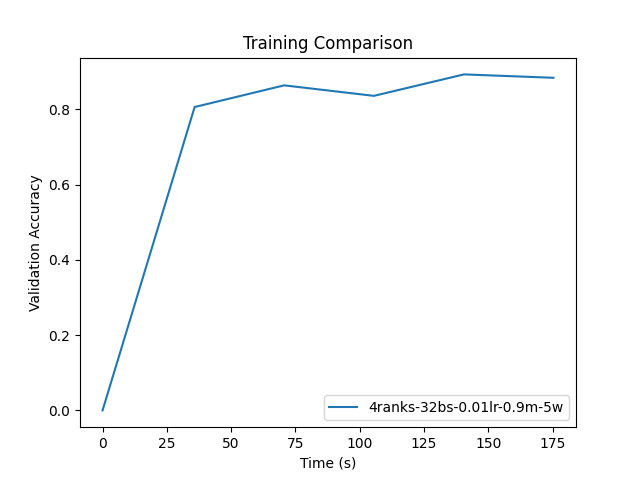

In [8]:
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt

# By default we skip the first row, which contains the headers
# By skipping 2 rows, you can disregard the first data-point (0,0) to get a closer look
def plot_trainings(skiprows=1):
    plt.close()
    for filename in os.listdir("training_data"):
        if filename == ".ipynb_checkpoints": continue
        x, y = np.loadtxt("training_data/" + filename, delimiter=',', unpack=True, skiprows=skiprows)
        plt.plot(x,y, label=filename.split('.csv')[0])

    plt.xlabel('Time (s)')
    plt.ylabel('Validation Accuracy')
    plt.title('Training Comparison')
    plt.legend()
    plt.show()
    
plot_trainings()

### Clearing up the Data

As you go through the following exercises in this lab, you may find that the graph will get cluttered and make it hard to compare trainings against each other. When that happens, we suggest that you go into the `training_data` folder and remove files as you see fit. You can clear up everything in the directory with:

In [9]:
# Only run this if you want to delete all training data
!rm -rf training_data/*

Also note that if you run a second training session with all the same hyperparameters (and thus uses the same name for the CSV file) it will overwrite the original training file.

## Adjusting the Optimizer: Adding Momentum

So far, we've modified our training by altering batch size, as well as distributing across multiple GPUs. We'll explore other hyperparameters, such as learning rate later in the lab. In this section, we'll explore another key tool in improving our training process: selecting and tuning the optimizer that we use. 

As you may recall in Lab 1, the optimizer updates the weights of the network in order to minimize the loss function. In the stochastic gradient descent optimizer that we've used so far, weights are updated based on their gradient with respect to the loss function of a mini-batch. In other words, we determine how altering a weight will affect the loss, and move a small step in the direction that minimizes that loss for the mini-batch. By taking those steps with each back-propagation, we slowly make our way toward a global minimum, decreasing our loss, and increasing our accuracy.

Though this process works well, it can be improved upon. One downside is that if the network gets near a local minimum or saddle point, the gradient can be quite small, and the training will slow down in that area. The noise introduced by using minibatches might help the model find its way out, but it might take some time. 

Additionally, there may be areas where the algorithm keeps taking steps in roughly the same direction. It would be advantageous in those areas if the optimizer helped us take larger steps to move toward the global minimum faster.

A good solution to these issues is to use momentum. Instead of the algorithm taking a small independent step each time, adding momentum to our optimizer allows the process to retain a memory of the last several steps. If the weights have been moving in a certain direction on average, momentum will help continue to propel the updates in the same direction. If the training is also fluctuating back and forth, it can smooth out this movement. A decent analogy is a ball rolling down a hill, which will pick up and retain momentum.

### Implementation

In this case implementing momentum is quite simple, as we do not have to alter the code of the optimizer. SGD algorithms will often accept a momentum parameter, as is the case in the PyTorch implementation.

Step 1: Alter the argument parser to accept a momentum argument:

```Python
parser.add_argument('--momentum', type=float, default=0.9,
                    help='SGD momentum')
```

Step 2: Pass the momentum into the optimizer:

```Python
optimizer = torch.optim.SGD(model.parameters(), lr=args.base_lr, momentum=args.momentum)
```

Step 3: Update the CSV filename to include the momentum hyperparameter:

```Python
data_filepath = "training_data/{}ranks-{}bs-{}lr-{}m.csv".format(WORLD_SIZE, args.batch_size, args.base_lr, args.momentum)
```

If you need any help, you can find the solution at `solutions/add_momentum.py`. Navigate to the `TODO: momentum` sections of fashion_mnist.py to make the three changes outlined above.

### Training with Momentum

Run the training again either for the same amount of time as before, or stopping at a certain accuracy using `--target-accuracy`. After the training completes, execute the plotting script to see the difference between training with and without momentum. 

In [10]:
!python3 fashion_mnist.py --num-gpus 4 --batch-size 32 --momentum .9

Epoch =  1: Cumulative Time = 35.784, Epoch Time = 35.784, Images/sec = 1674.0355224609375, Validation Loss = 0.555, Validation Accuracy = 0.796
Epoch =  2: Cumulative Time = 70.583, Epoch Time = 34.799, Images/sec = 1720.53369140625, Validation Loss = 0.393, Validation Accuracy = 0.860
Epoch =  3: Cumulative Time = 105.469, Epoch Time = 34.885, Images/sec = 1717.166259765625, Validation Loss = 0.398, Validation Accuracy = 0.860
Early stopping after epoch 3
Early stopping after epoch 3
Early stopping after epoch 3
Early stopping after epoch 3


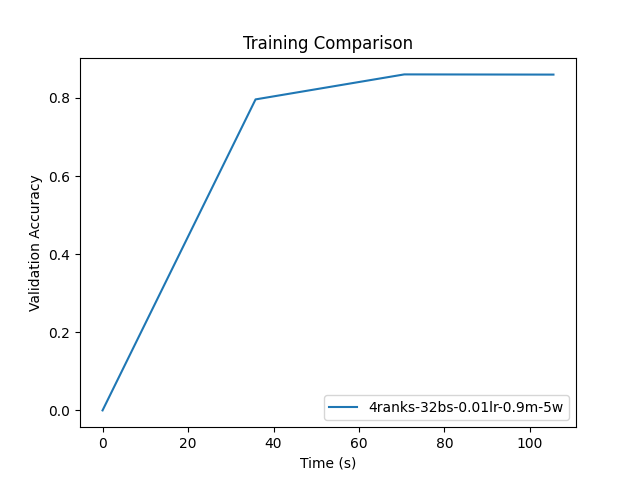

In [11]:
plot_trainings()

<img src="./images/DLI_Header.png">